## Conclusions 
- Accurate Speed esitmation Via Mobile GPS isn't feasible
- Someone is fucking with the GSMlocation feature in the SIM868
    - Maybe poor calibration (again I found this accidentally )
    - Maybe the mother fucking gov
- SIM868 is pretty darn accurate however getting accuracy info isn't relaible unless it's 1-10 (measured in DOP not METERS!)
- SIM868 GPS speed data seems pretty skookum but still needs further testing

## Further Expirements/Questions
- who is fucking up the GSM location data? could it be the gov?
- is Accurate Speed via SIM868 SIM achivable?
    - same test but remove the CLIB thing
- is google maps geolocation API even an option?
    - https://developers.google.com/maps/documentation/geolocation/overview ?

In [82]:
%matplotlib inline
import matplotlib.pyplot as plt
import sqlite3 
import numpy as np
import os
import pprint
import tilemapbase
tilemapbase.start_logging()
tilemapbase.init(create=True)
t = tilemapbase.tiles.build_OSM()

#clib_data.txt
#mohamedemad4.pythonanywhere.com.access.log
#its_app.db

In [83]:
#https://simcom.ee/documents/SIM800x/SIM800%20Series_GSM%20Location_Application%20Note_V1.01.pdf
lat_lon=[]
for i in open("clib_data.txt").read().split("\n"):
    if "CLBS" in i and not (""):
        try:
            lat=i.split(",")[2]
            lon=i.split(",")[1]
            #print("date:",i.split(",")[4],i.split(",")[5].split("\\")[0] )
            if [lat,lon] in lat_lon:
                continue
            else:
                print(lat,lon)
                #print("found uniqe")
                lat_lon.append([lat,lon])
        except:
             pass

gsm_clib_lat_lon=lat_lon

29.944199 30.920762
29.943236 30.918584
29.952164 30.911274
29.951894 30.912080
29.951865 30.912030
29.943849 30.919334


In [84]:
##self.c.execute('''CREATE TABLE car_spd
#(car_token VARCHAR(255),lat REAL,lot REAL,speed REAL,accuracy REAL,Unixtimestamp BIGINT)''')
# first CLIB data capture 1595752603
conn=sqlite3.connect('its_app.db')
cur=conn.cursor()
cur.execute("SELECT * from car_spd where Unixtimestamp>1595752603 and car_token='test-token'")
gsm_mode_gps_data=cur.fetchall()
cur.execute("SELECT * from car_spd where Unixtimestamp>1595752603 and car_token='car1'")
phone_gps_data=cur.fetchall()

avg time between samples (s) 287.4665379073169
0.0
58.4


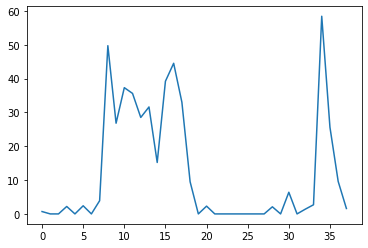

In [85]:
#car speed according to SIM868 GPS sensor
spd=[i[3] for i in gsm_mode_gps_data if i[3]<100]
time=[i for i in range(len(spd))]
gsm_gps_mod_locs=[(i[1],i[2]) for i in gsm_mode_gps_data if i[4]<20 and i[1]>20 and i[2]>20]
print("avg time between samples (s)",np.average([gsm_mode_gps_data[i+1][-1]-gsm_mode_gps_data[i][-1] for i in range(len(gsm_mode_gps_data)) if i!=len(gsm_mode_gps_data)-1]))
plt.plot(time,spd)
print(min(spd))
print(max(spd))

avg time between samples (s) 0.6232504820835585
0.0
16.829999923706055


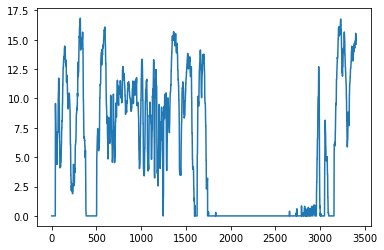

In [86]:
#car speed according to fancy pansy phone GPS
spd=[i[3] for i in phone_gps_data if i[3]<100 and i[4]<20] #exclude GPS accuracy over 20meters
time=[i for i in range(len(spd))]
phone_gps_locs=[(i[1],i[2]) for i in phone_gps_data if i[4]<20 and i[1]>20 and i[2]>20] #>20s are just to clean some junk data
plt.plot(time,spd)
print("avg time between samples (s)",np.average([phone_gps_data[i+1][-1]-phone_gps_data[i][-1] for i in range(len(phone_gps_data)) if i!=len(phone_gps_data)-1]))
print(min(spd))
print(max(spd))

In [87]:
def plot_gps_cords(cords_array):
    """just how it sounds cords_array should look like [[lat,lon]]"""
    #here we are lon,lat not lat,lon
    loc_arr=np.array([ (i[1],i[0]) for i in cords_array])

    set_extent_max = np.max(loc_arr[:,0]),np.max(loc_arr[:,1])
    set_extent_min = np.min(loc_arr[:,0]),np.min(loc_arr[:,1])

    extent=tilemapbase.Extent.from_lonlat(set_extent_min[0],set_extent_max[0],set_extent_min[1],set_extent_max[1])

    #extent = extent.to_aspect(1)
    fig, ax = plt.subplots(figsize=(16, 16), dpi=100)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    plotter = tilemapbase.Plotter(extent, t,width=700)
    plotter.plot(ax, t)

    geo_x=[]
    geo_y=[]
    for i in loc_arr:
        x, y = tilemapbase.project(i[0],i[1])
        geo_x.append(x)
        geo_y.append(y)
    ax.scatter(geo_x,geo_y, marker="x", color="black", linewidth=5)

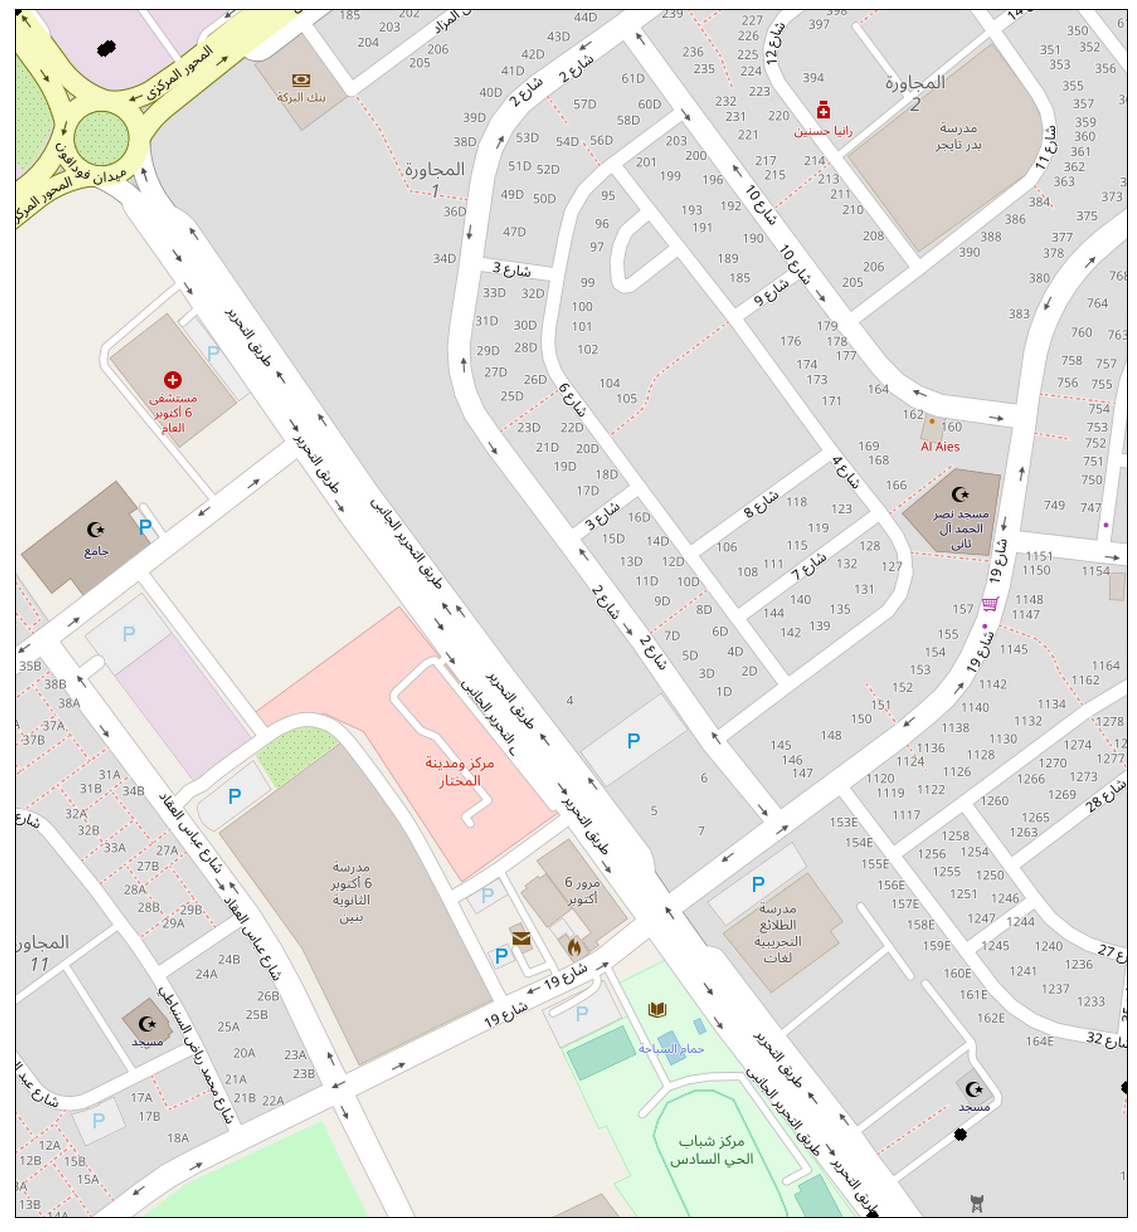

In [89]:
#not as accurate and the sampling rate ain't great
#but Hey!

gsm_clib_lat_lon = [[float(i[0]),float(i[1])]  for i in  gsm_clib_lat_lon]
plot_gps_cords(gsm_clib_lat_lon)

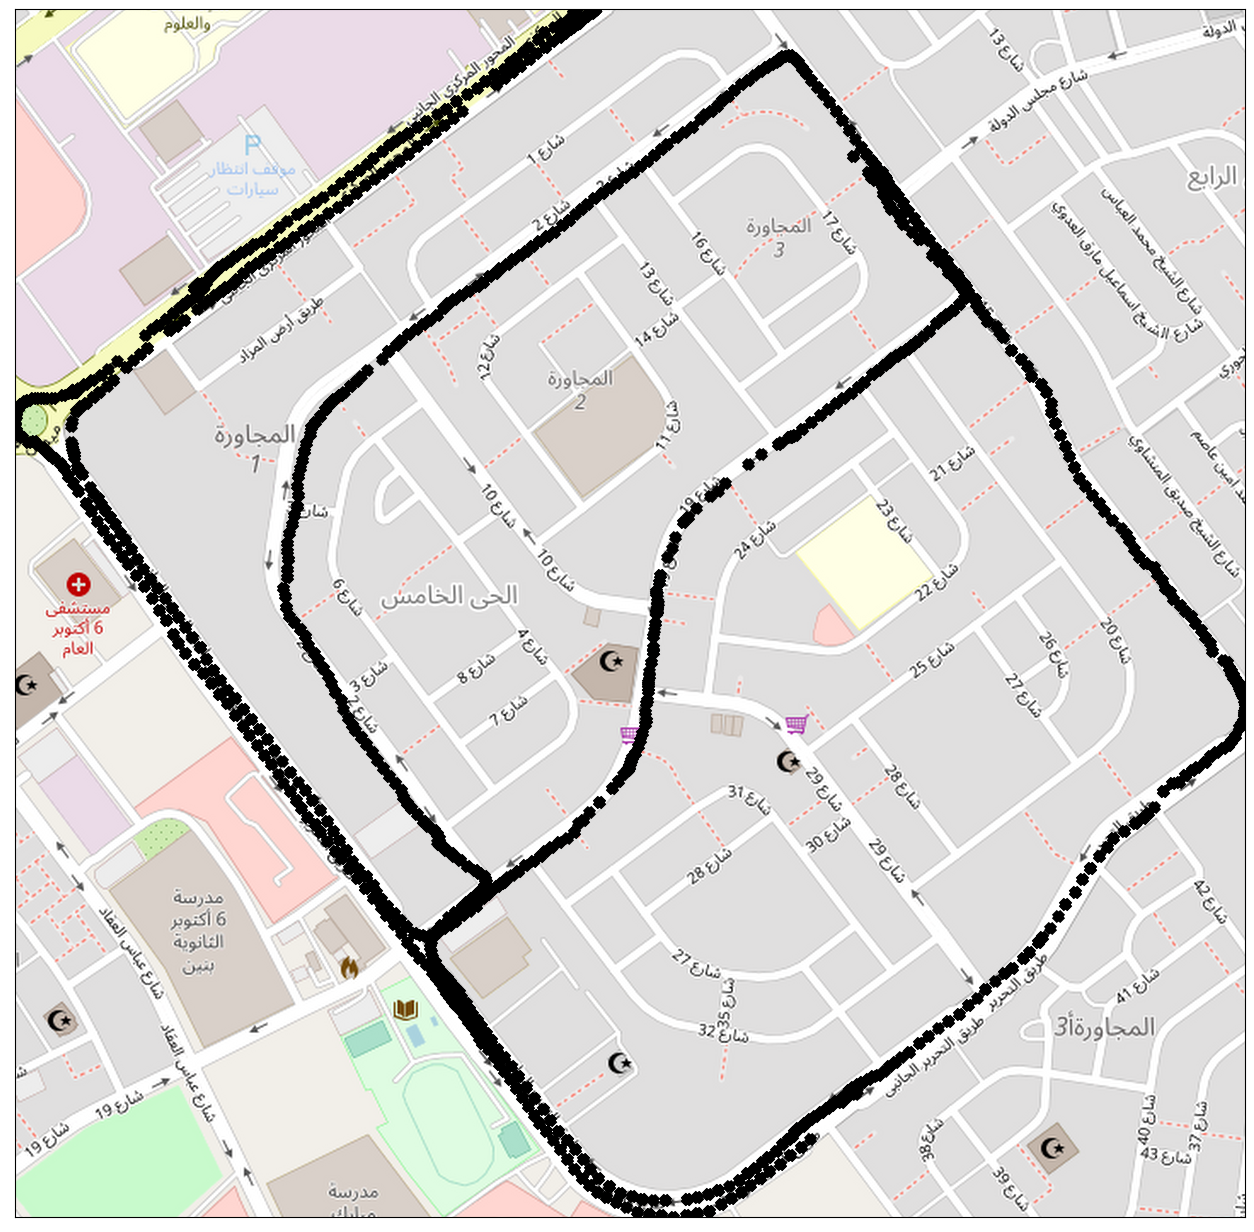

In [76]:
plot_gps_cords(phone_gps_locs)

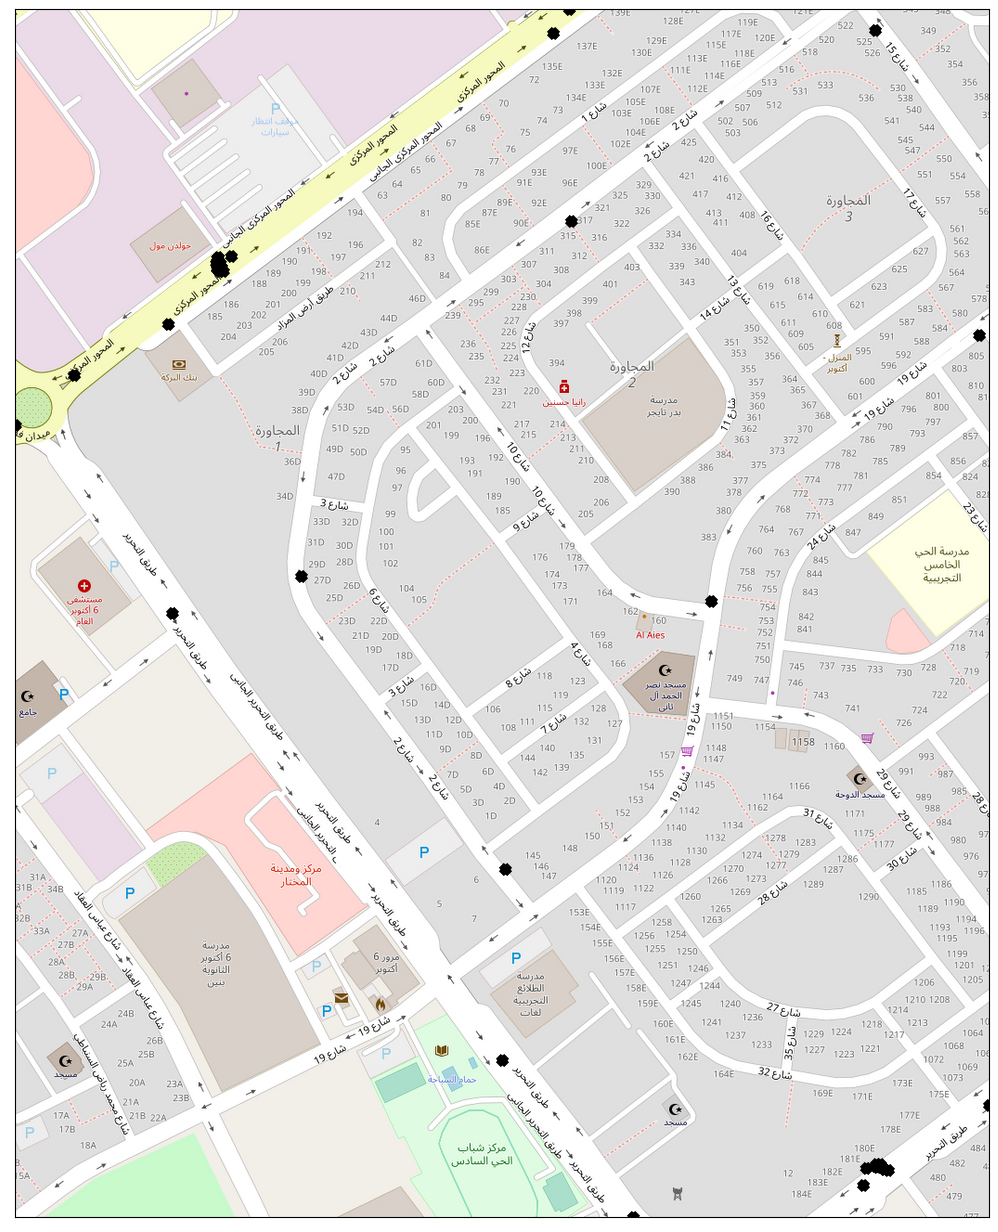

In [79]:
plot_gps_cords(gsm_gps_mod_locs)